# Baselines

## Test
### Motivation

Create a set of baselines for demand prediction using conventional methods:

* time series prediction
* per cell prediction using any type of regressor, e.g. gradient boosting regressor

**TODO**
- define a small area 10x10 squares
- explore demand over time changes - how small time prediction intervals should be

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
data = pd.read_feather('../data/train_sample.feather')

data.head(3)

,pickup_datetime,dropoff_datetime,passenger_count,distance,pickup_lon,pickup_lat,dropoff_lon,dropoff_lat
0,2015-01-01 00:00:00,2015-01-01 00:00:00,3,2.510570,-74.001320,40.729057,-74.010208,40.719662
1,2015-01-01 00:00:03,2015-01-01 00:10:50,1,2.542757,-73.987579,40.765270,-73.976921,40.776970
2,2015-01-01 00:00:03,2015-01-01 00:21:48,2,4.136004,-73.969017,40.754269,-73.994133,40.761600


Create a grid and count the *number of requests per cell*

## Select a small area

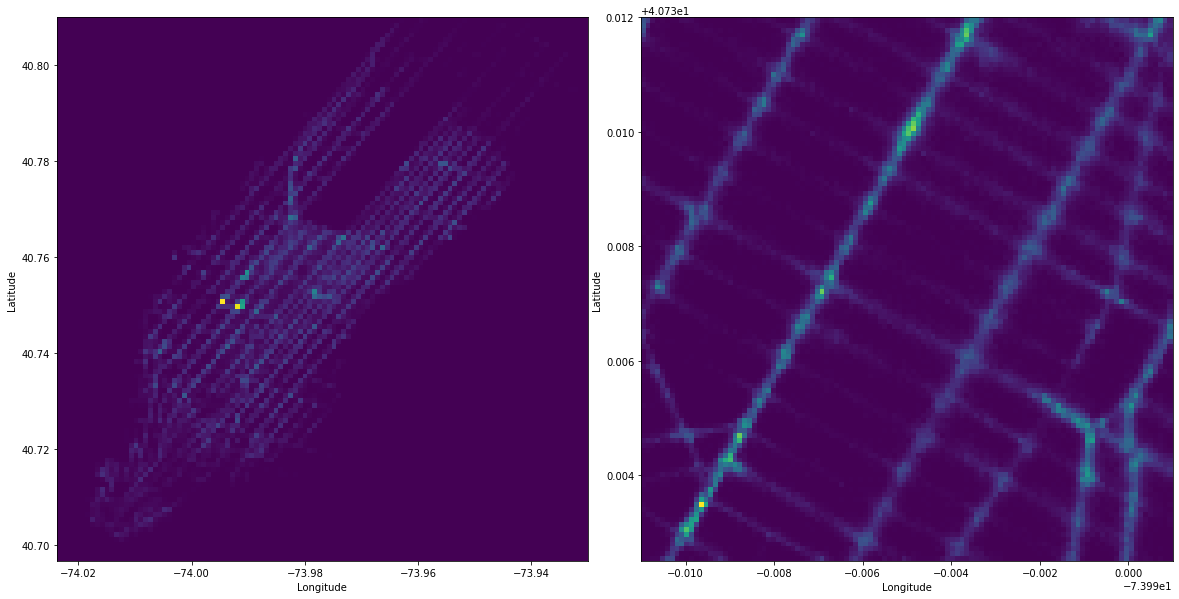

In [15]:
plt.figure(figsize=(20, 10))

bounding_box = ((-74.0238, -73.93), (40.6967, 40.81))

sample_box = ((-74.001, -73.989), (40.7325, 40.742))

bins = (110, 110)

for i, box in enumerate([bounding_box, sample_box]):
    plt.subplot(1, 2, i + 1)
    
    plt.hist2d(
        data.pickup_lon,
        data.pickup_lat,
        range=box, bins=bins)

    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

## Number of requests per day

In [4]:
def calc_hist(data, bins, value_range):
    hist, _, _ = np.histogram2d(data.pickup_lon,
                                data.pickup_lat,
                                range=value_range,
                                bins=bins)
    
    return hist.astype(int)

Total on 2015-01-15: 12865
Total on 2015-01-10: 22593
Total on 2015-01-5: 12971
Total on 2015-01-1: 11162


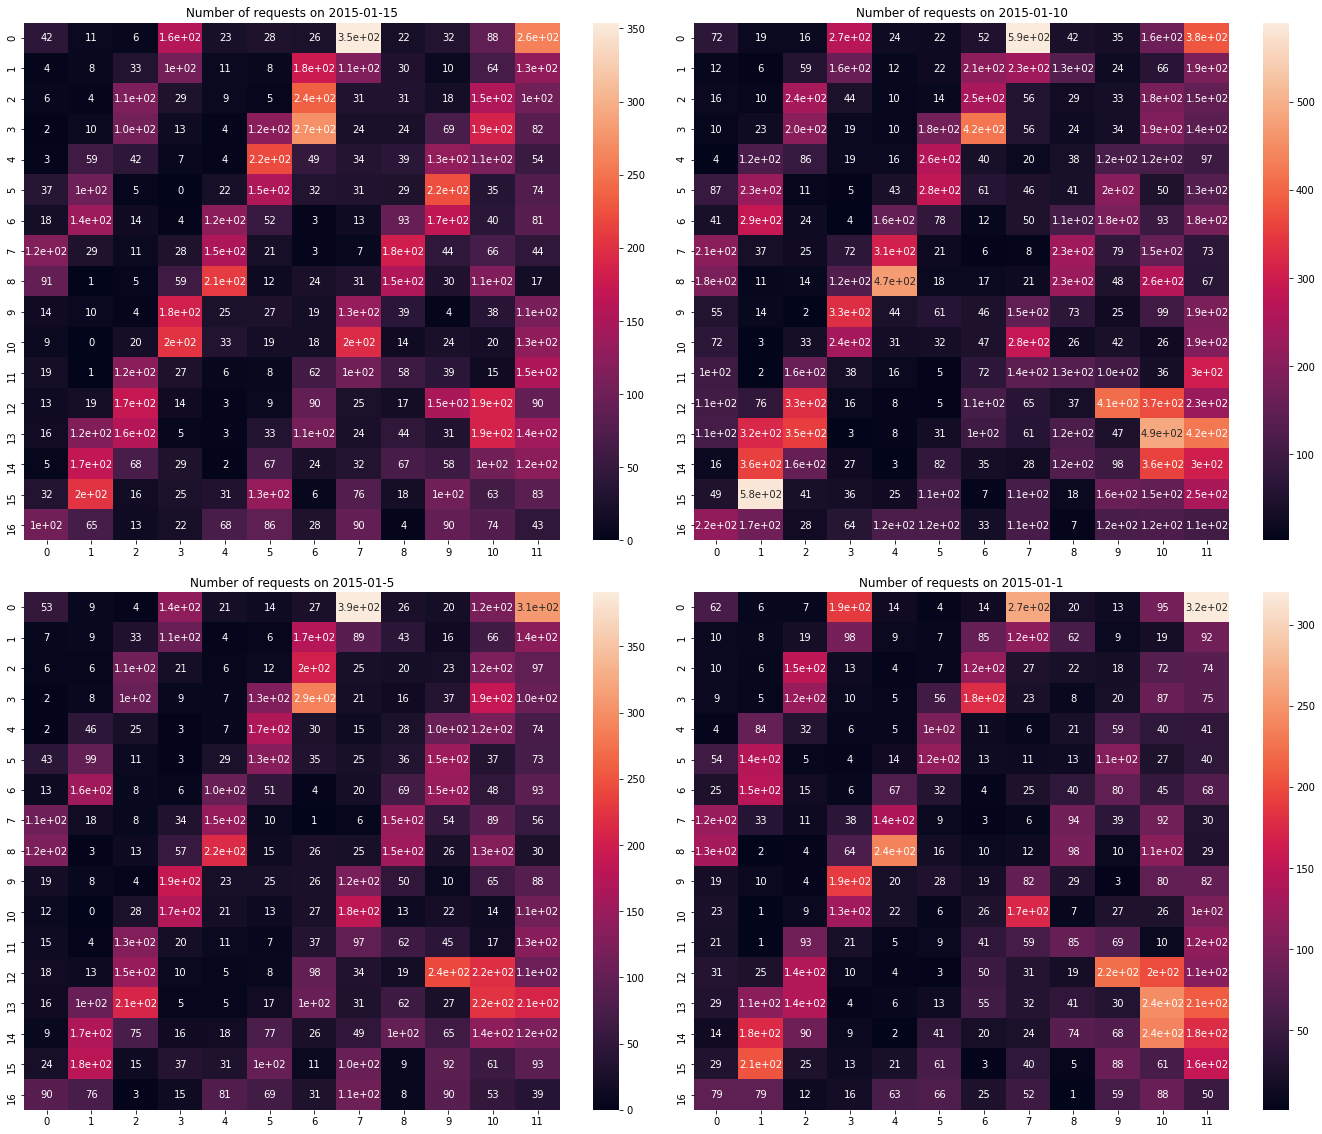

In [5]:
plt.figure(figsize=(24, 20))

bins = (12, 17)
dates = ['2015-01-15', '2015-01-10', '2015-01-5', '2015-01-1']

for i, date in enumerate(dates):

    plt.subplot(2, 2, i + 1)

    idx = data.pickup_datetime.dt.date == pd.to_datetime(date)    
    hist = calc_hist(data[idx], bins, sample_box)

    print(f'Total on {date}: {int(hist.sum())}')

    plt.title(f'Number of requests on {date}')
    sns.heatmap(np.flip(np.fliplr(hist.T)), annot=True)

plt.subplots_adjust(wspace=0, hspace=0.1)

## Number of requests per hour

Total at 6: 371
Total at 10: 816
Total at 16: 743
Total at 19: 1250


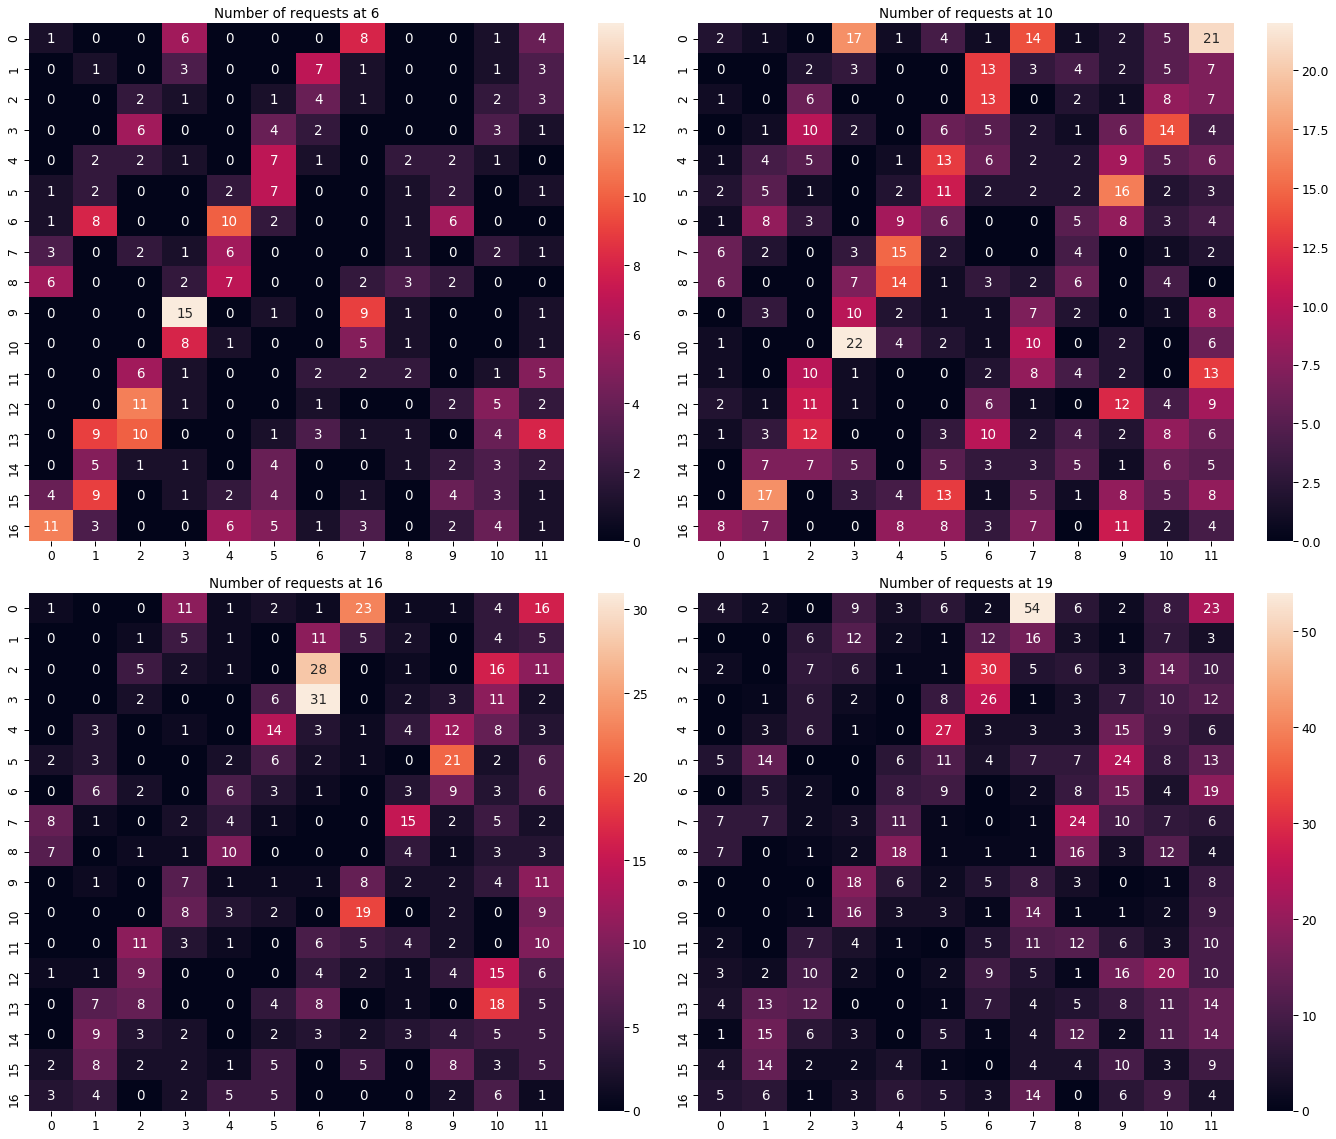

In [6]:
plt.figure(figsize=(24, 20))

bins = (12, 17)
date = '2015-01-15'

# scale font for readability
with sns.plotting_context('paper', font_scale=1.4):
    
    for i, hour in enumerate([6, 10, 16, 19]):

        plt.subplot(2, 2, i + 1)

        idx = (data.pickup_datetime.dt.date == pd.to_datetime(
            date)) & (data.pickup_datetime.dt.hour == hour)
        hist = calc_hist(data[idx], bins, sample_box)

        print(f'Total at {hour}: {int(hist.sum())}')

        plt.title(f'Number of requests at {hour}')
        sns.heatmap(np.flip(np.fliplr(hist.T)), annot=True)

    plt.subplots_adjust(wspace=0, hspace=0.1)

## Create a demand dataset

* remove all data outside of the prediction area
* remove unnecessary columns
* create a grid and map each data point to a cell of the grid

### Demand dataset

In [7]:
demand_data = data[
    (data.pickup_lon >= sample_box[0][0]) &
    (data.pickup_lon <= sample_box[0][1]) &
    (data.pickup_lat >= sample_box[1][0]) &
    (data.pickup_lat <= sample_box[1][1])
]

demand_data = demand_data[['pickup_datetime', 'pickup_lon', 'pickup_lat']]
demand_data.columns = ['datetime', 'lon', 'lat']

demand_data.head(3)

,datetime,lon,lat
36,2015-01-01 00:00:30,-73.990891,40.738850
49,2015-01-01 00:00:52,-73.999908,40.732853
52,2015-01-01 00:00:54,-73.990509,40.735027


### Create a grid

In [8]:
# cell_size x cell_size grid
cell_size = 20

xcells = np.linspace(sample_box[0][0], sample_box[0][1], cell_size)
demand_data['x_cell'] = np.digitize(demand_data.lon, xcells)

ycells = np.linspace(sample_box[1][0], sample_box[1][1], cell_size)
demand_data['y_cell'] = np.digitize(demand_data.lat, ycells)

demand_data['cell'] = demand_data.apply(
    lambda item: '{}-{}'.format(item.x_cell, item.y_cell), axis=1)

demand_data.head(5)

,datetime,lon,lat,x_cell,y_cell,cell
36,2015-01-01 00:00:30,-73.990891,40.738850,17,13,17-13
49,2015-01-01 00:00:52,-73.999908,40.732853,2,1,2-1
52,2015-01-01 00:00:54,-73.990509,40.735027,17,6,17-6
86,2015-01-01 00:01:19,-73.999855,40.732891,2,1,2-1
121,2015-01-01 00:01:41,-73.991455,40.738789,16,13,16-13


## Remove noise

It doesn't make sense to predict demand in cells with very low number of requests. The question what level of demand is *low*?

From a business point of view, for example a taxi company, it is important to predict locations and level of high demand, not areas with few requests per day.

Text(0, 0.5, 'Num requests')

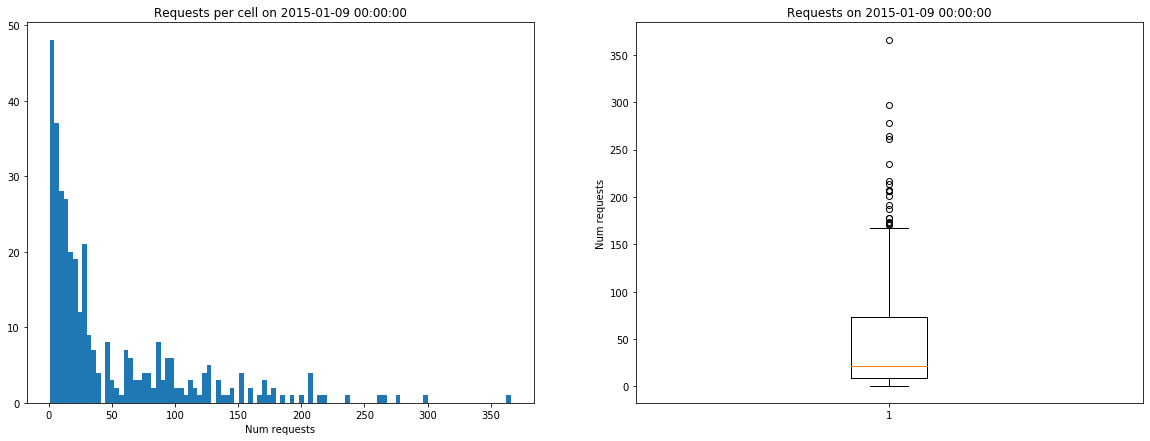

In [9]:
plt.figure(figsize=(20, 7))

date = pd.to_datetime('2015-01-09')
idx = demand_data.datetime.dt.date == date

agg_demand = demand_data[idx].groupby('cell').cell.count()

plt.subplot(121)
plt.title(f'Requests per cell on {date}')
plt.hist(agg_demand, bins=100)
plt.xlabel('Num requests')

plt.subplot(122)
plt.boxplot(agg_demand, meanline=True)
plt.title(f'Requests on {date}')
plt.ylabel('Num requests')

Detect areas with high demand per day, check how demand changes in those areas during some period of time

In [10]:
(agg_demand.values > 10).sum()

248

In [11]:
# plt.figure(figsize=(10, 5))

# plt.title('Requests per day')
# plt.xlabel('Day')
# demand_data.groupby(
#     demand_data.datetime.dt.date).datetime.count().plot(kind='bar');